In [131]:
import contractions
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import string
from typing import List

from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from strictly_typed_pandas import DataSet
from textblob import TextBlob

In [132]:
pd.options.display.max_colwidth = 500
pd.options.display.max_rows = 500

In [133]:
sns.set_theme()

In [134]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/troyjennings/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [135]:
stopwords = stopwords.words('english')

# Problem Evaluation Metrics

We need to first think about the impact of:

- `False Positives`: The model flags a review as `not-recommended` when it shouldn't
    - With more false positives, the model will be flagging items that aren't actually concerning since they would recommended by the human reviewer. This is probably acceptable since one of the business goals is brand-protection. 

- `False Negatives`: The model flags a review as `recommended` when it shouldn't
    - With more false negatives, the model will fail to flag items that are not recommended by the human reviewer. Since one of the business goals is brand-protection, this is not an acceptable situation.

Since the impact of false negatives on the business have higher potential ramifications, we would prioritize minimization of false negatives. Given this situation, we will elect to choose a model which `maximizes recall`.

# Confusion Matrix Cheatsheet
- `Recall/Sensitivity`: measure the ability to predict positive observations
    - What proportion of positive observations were correctly predicted by the model?
    - How often does the model choose the positive class when the observation is in fact the positive class?
    - Shows if the `classifier is able to detect a giving class at all`
    - `Usage`: when the cost of false negatives are high
- `Specificity`: measure the ability of the model to predict the negative observations
    - What proportion of the negative observations were correctly predicted by the model?
- `Precision`: measure the number of observations correctly predicted to be in the positive class over all observations predicted to be in the positive class
    - What proportion of observations predicted to be in the positive class were correctly predicted?
    - Shows if the `classifier is able to differ one class from all others`
    - `Usage`: when the cost of false positives are high
    - 👀: we want a lower number in the upper-right quadrant (predicted positive actual negative)
- `F1`: harmonic mean of `precision` and `recall`
    - `Usage`: when we seek a balance between `precision` and `recall` AND there is an uneven class distribution

# References
- https://nijianmo.github.io/amazon/index.html for testing
- https://www.kaggle.com/datasets/nicapotato/womens-ecommerce-clothing-reviews for training
- https://towardsdatascience.com/the-f1-score-bec2bbc38aa6 for metrics

# Data Loading

In [136]:
labeled_data = pd.read_csv('../data/raw/raw_review_data.csv')
labeled_data.sample(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
6532,6532,1095,33,Stunning,"This jumpsuit runs large so i sized down perfectly one full size down. i have a size b chest and was very comfortable with no bra, as the built in cups gave me the perfect coverage. it looked like a dress standing, but had such a flattering and fun shape when you move. everyone loved it!",5,0,0,General,Dresses,Dresses
19233,19233,1078,43,Simply timeless and feminine,"I bough this dress in blue and i cannot tell you the compliments and the looks i get on the street! no kidding! this is a beautiful dress which has a very feminine/romantic quality to it. i bought size 4 and it sits perfectly on my waist i completely fell in love with that dress and especially with the lace work and the design. this is a classic piece, that is always going to be timeless in my opinion. no regret at all to have bought it!",5,1,7,General,Dresses,Dresses
4883,4883,984,66,Perfect white jean jacket,Love this white jean jacket! love the stretchy fit.,5,1,0,General Petite,Jackets,Jackets
5364,5364,1095,41,Great dress!,"I'm 6 ft tall and usually wear a size 10/12, but had to size up to a 14 because this dress runs a bit small around the waist. it's a beautiful dress. it hit me right below the knee, so might be long on shorter gals. i received many compliments on this dress. the colors are beautiful. the main color of the dress is a dark navy. it looked black online. definitely buy this dress! it's a great work dress and you won't be sorry that you did.",5,1,0,General Petite,Dresses,Dresses
23457,23457,262,49,Adorable,"These pants are soft, fun print and comfy. they are a drop crotch, but the cut is flattering without bunching up between legs. they are perfect for pjs all day type day!",5,1,3,General Petite,Intimate,Lounge


In [137]:
# rename columns
reviews_labeled = labeled_data[['Review Text', 'Recommended IND']]
reviews_labeled.columns = ['review_text', 'recommended']
reviews_labeled.sample(5)

,review_text,recommended
13461,"It was a hard decision, but i'm returning these. they're definitely pretty and well-made. they drape nicely. ultimately, they are too high-waisted and too billowy for most of my tops (which are mostly long and billowy). these trousers are too nice to wear with most of my fitted tanks. even a normal-length t-shirt, untucked, draped weirdly and came down too far on these high-waisted pants. i guess they're too ""formal"" for what i had in mind - pictured them more like a maxi skirt. if they were...",0
1534,NaN,1
8703,"I am 5'6"" and wear a medium. i ordered an 8 and a 10 and am keeping the 10, which is a little large but, importantly, is a full 2 inches longer than the 8. this is important to me because several of my casual pants begin a couple of inches below the waist and, as noted by another reviewer, and as is evident on the model, the top hits just below the waist. also, it is cotton/linen and may shrink (since it is ivory, i assume it will see a few washings). i don't want to worry about the ""gap"", b...",1
5079,"This top is beautiful in person, love the buttons in the back, fits a little boxy but i like that style",1
20253,"This is a classic, well made, velvet top. it fits true to size, is very flattering ,the on- line photos don't do it justice. very pretty in real life. 34a 123 lbs ordered the xs.",1


# Preprocessing

- Remove mising review text
- Document Preprocessing (remove stopword and punctuation)
- (Length Analysis) Add word count (non-stopword) feature
- (Sentiment Analysis) Add sentiment score feature(s)
- (Word Frequency) 
- (Relabel for the negative case) Since we are focusing on 'not-recommended' as the target classification, we need to swap the labels such that 1 = `not-recommended` and 0 = `recommended`


In [138]:
def cleanse_document(doc: str) -> str:
    '''
    Cleanse a document of stopwords and punctuation.

    Parameters
    ----------
    doc : List[str]
        A list of document strings (reviews).

    Returns
    -------
    clean_doc : str
        A cleansed document string.
    '''
    stops = stopwords

    # handle contraction splitting
    clean_tokenized_doc = []
    for token in doc.split(' '):
        t = contractions.fix(token)
        clean_tokenized_doc.extend(t.split(' '))
    clean_tokenized_doc = ' '.join(clean_tokenized_doc)

    # handle punctuation and numbers
    clean_tokenized_doc = ''.join([ char for char in clean_tokenized_doc if char not in string.punctuation and not char.isdigit() ])
    # # handle stopwords
    clean_tokenized_doc = [ token.lower() for token in clean_tokenized_doc.split() if token.lower() not in stops ]

    return clean_tokenized_doc

### Feature Engineering

In [139]:
# remove null reviews
print(f'Shape before dropping Nan: {reviews_labeled.shape}')
reviews_labeled = reviews_labeled.dropna()
print(f'Shape after dropping Nan: {reviews_labeled.shape}')

Shape before dropping Nan: (23486, 2)
Shape after dropping Nan: (22641, 2)


In [140]:
# add clean, tokenized review feature
clean_doc_tokens = reviews_labeled['review_text'].apply(lambda review: cleanse_document(review))
reviews_labeled.insert(len(reviews_labeled.columns), 'clean_tokenized_review', clean_doc_tokens)
reviews_labeled.sample(5)

,review_text,recommended,clean_tokenized_review
5600,Got the mustard and grey. very cute. looking forward to wearing it,1,"[got, mustard, grey, cute, looking, forward, wearing]"
23319,"I saw this on a girl at the winery where i work and i thought to myself - i have to have that top! it is perfect for the fall season. the pattern/print is very intricate and lovely. i think it fits true to size - the petite xxs is just right. the sleeves do not come to the wrist, but the photo here depicts that already. the elastic in the arms feel a little tight, but that would be my own negative comment. the fabric is beautiful and flows just right - it does not feel to big to me at all. i...",1,"[saw, girl, winery, work, thought, top, perfect, fall, season, patternprint, intricate, lovely, think, fits, true, size, petite, xxs, right, sleeves, come, wrist, photo, depicts, already, elastic, arms, feel, little, tight, would, negative, comment, fabric, beautiful, flows, right, feel, big]"
4911,This sweater is a nice addition to a fall or spring wardrobe. it must be layered as it is sheer. i read a review about snagging but i have not had this issue as of yet.,1,"[sweater, nice, addition, fall, spring, wardrobe, must, layered, sheer, read, review, snagging, issue, yet]"
17927,"The blue color is beautiful and what attracted me to this sweater. the draped front is very flattering and the fit is true to size. unfortunately the banded hem creates a pouching effect that is very unflattering. i really wanted to love this sweater, but just can't figure out how to wear it without poofing. i think this is the reason it is tucked in in many of the model shots. it is still a pretty sweater and it may work with for some.",1,"[blue, color, beautiful, attracted, sweater, draped, front, flattering, fit, true, size, unfortunately, banded, hem, creates, pouching, effect, unflattering, really, wanted, love, sweater, cannot, figure, wear, without, poofing, think, reason, tucked, many, model, shots, still, pretty, sweater, may, work]"
19221,Top opens in the middle right in front. should have some sort of closure inside to prevent this top from flying open will return,0,"[top, opens, middle, right, front, sort, closure, inside, prevent, top, flying, open, return]"


In [141]:
# add non-stopword word count
reviews_labeled['n_tokens'] = reviews_labeled['clean_tokenized_review'].apply(lambda t: len(t))
reviews_labeled.sample(5)

,review_text,recommended,clean_tokenized_review,n_tokens
225,"I love paige brand pants-they are soft, comfortable, and forgiving. i love these, and want them badly. the are still tight all the way to the knee and then go out into a flattering flare-it is difficult to find the perfect fit on something like this-and paige has done a wonderful job for my body.\n\nmy store does not carry petite so i tried these on in regular length. they were significantly too long for me (5'3"") probably 3-4 inches to long. i am hoping for a sale so i can buy them in petit...",1,"[love, paige, brand, pantsthey, soft, comfortable, forgiving, love, want, badly, still, tight, way, knee, go, flattering, flareit, difficult, find, perfect, fit, something, like, thisand, paige, done, wonderful, job, body, store, carry, petite, tried, regular, length, significantly, long, probably, inches, long, hoping, sale, buy, petite]",44
21191,"The pictures are not showing how absolutely spectacular this caftan is. it is very delicate (even says so on the tag) and lightweight so that you won't dread wearing it in the heat of the day. by what doesn't show up is that this caftan shimmers-there is gold string woven throughout the entire garment which gives it a slight sheen. it adds significantly to the impact of the garment, and i love this detail. i love the way this caftan drapes, and i love that it is longer than a normal caftan. the",1,"[pictures, showing, absolutely, spectacular, caftan, delicate, even, says, tag, lightweight, dread, wearing, heat, day, show, caftan, shimmersthere, gold, string, woven, throughout, entire, garment, gives, slight, sheen, adds, significantly, impact, garment, love, detail, love, way, caftan, drapes, love, longer, normal, caftan]",40
17542,"This dress is beautiful. i ordered this in the mail and literally said ""wow"" when i took it out of the packaging. the color looks more like champagne in person and the flowers look fantastic on it. i was worried that it might look a little awkward with so many things hanging off, but instead the flowers really compliment the entire ensemble. it really just looks like a work of art. i'm usually a small in retailer clothes and that size fits me very well. i absolutely love this dress.",1,"[dress, beautiful, ordered, mail, literally, said, wow, took, packaging, color, looks, like, champagne, person, flowers, look, fantastic, worried, might, look, little, awkward, many, things, hanging, instead, flowers, really, compliment, entire, ensemble, really, looks, like, work, art, usually, small, retailer, clothes, size, fits, well, absolutely, love, dress]",46
8774,These jeans look better in person - the pattern is more subtle than the picture online. these run true to size for ag denim.,1,"[jeans, look, better, person, pattern, subtle, picture, online, run, true, size, ag, denim]",13
13932,"This dress was a 'maybe' for me online but when i tried it on i was totally won over! i got the raspberry, which is a really pretty color. i have 34dd chest and it fits nicely on me, fairly true to size and is super flattering on me- more so than most swing dresses. love it.",1,"[dress, maybe, online, tried, totally, got, raspberry, really, pretty, color, dd, chest, fits, nicely, fairly, true, size, super, flattering, swing, dresses, love]",22


In [142]:
# lemmatize to facilitate sentiment scoring
wn_lemmatizer = WordNetLemmatizer()

reviews_labeled['lemma'] = reviews_labeled['clean_tokenized_review'].apply(lambda text: [ wn_lemmatizer.lemmatize(word, pos='v') for word in text ])
reviews_labeled['lemma_sent'] = reviews_labeled['lemma'].apply(lambda r: ' '.join(r))
reviews_labeled.sample(5)

,review_text,recommended,clean_tokenized_review,n_tokens,lemma,lemma_sent
3875,"This one is a must-buy. i have 3 of the longer sleeve version (the tegan dress) and one of these. i am about to buy more of the lola/ short sleeved version. these dresses are flattering and comfortable. they can be worn as a tunic with leggings or a dress. they are great for travel. if you roll them, they don't wrinkle. they can be dressed up or down. my sister and i have very different figures and this dress looks great on both of us. i can't recommend a dress more. the lola and the tegan a...",1,"[one, mustbuy, longer, sleeve, version, tegan, dress, one, buy, lola, short, sleeved, version, dresses, flattering, comfortable, worn, tunic, leggings, dress, great, travel, roll, wrinkle, dressed, sister, different, figures, dress, looks, great, us, cannot, recommend, dress, lola, tegan]",37,"[one, mustbuy, longer, sleeve, version, tegan, dress, one, buy, lola, short, sleeved, version, dress, flatter, comfortable, wear, tunic, leggings, dress, great, travel, roll, wrinkle, dress, sister, different, figure, dress, look, great, us, cannot, recommend, dress, lola, tegan]",one mustbuy longer sleeve version tegan dress one buy lola short sleeved version dress flatter comfortable wear tunic leggings dress great travel roll wrinkle dress sister different figure dress look great us cannot recommend dress lola tegan
1181,"I really wanted to like his dress, but it was a big miss. big big miss. look at the way the skirt is attached to the dress in the photo. it goes up high on the sides leaving a short bodice. the sequined patterns hit right at my breasts, so it looked like glittery bra cups on the front. the back glittery pattern looked like bird wings on my back. it was far shorter than i expected. overall, it looked like i was desperately trying to be a sexy angel or fairy. bad bad bad.",0,"[really, wanted, like, dress, big, miss, big, big, miss, look, way, skirt, attached, dress, photo, goes, high, sides, leaving, short, bodice, sequined, patterns, hit, right, breasts, looked, like, glittery, bra, cups, front, back, glittery, pattern, looked, like, bird, wings, back, far, shorter, expected, overall, looked, like, desperately, trying, sexy, angel, fairy, bad, bad, bad]",54,"[really, want, like, dress, big, miss, big, big, miss, look, way, skirt, attach, dress, photo, go, high, side, leave, short, bodice, sequined, pattern, hit, right, breast, look, like, glittery, bra, cup, front, back, glittery, pattern, look, like, bird, wing, back, far, shorter, expect, overall, look, like, desperately, try, sexy, angel, fairy, bad, bad, bad]",really want like dress big miss big big miss look way skirt attach dress photo go high side leave short bodice sequined pattern hit right breast look like glittery bra cup front back glittery pattern look like bird wing back far shorter expect overall look like desperately try sexy angel fairy bad bad bad
1593,"This is a beautiful dress, considering it is made from polyester. that being said, the material has a nice finish and looks like it could be silk. it's a flattering cut (other than being a tad short-waisted) and hangs well. it was also a bit tight through the bust. unfortunately, if you are on the taller side, it tends to be high waisted and short in length.my daughter is 5'11"" and a size 10. the medium fit best, although because of the length, she is reluctantly returning it. sad, because i...",1,"[beautiful, dress, considering, made, polyester, said, material, nice, finish, looks, like, could, silk, flattering, cut, tad, shortwaisted, hangs, well, also, bit, tight, bust, unfortunately, taller, side, tends, high, waisted, short, lengthmy, daughter, size, medium, fit, best, although, length, reluctantly, returning, sad, ha]",42,"[beautiful, dress, consider, make, polyester, say, material, nice, finish, look, like, could, silk, flatter, cut, tad, shortwaisted, hang, well, also, bite, tight, bust, unfortunately, taller, side, ten

In [143]:
# calculate sentiment scores
reviews_labeled[['polarity', 'subjectivity']] = reviews_labeled['lemma'].apply(lambda text: pd.Series(TextBlob(' '.join(text)).sentiment))

for index, row in reviews_labeled['lemma'].iteritems():
	score = SentimentIntensityAnalyzer().polarity_scores(' '.join(row))
	neg = score['neg']
	neu = score['neu']
	pos = score['pos']
	comp = score['compound']

	if neg > pos:
		reviews_labeled.loc[index, 'sentiment'] = 'negative'
	elif pos > neg:
		reviews_labeled.loc[index, 'sentiment'] = 'positive'
	else:
		reviews_labeled.loc[index, 'sentiment'] = 'neutral'
	# # Set the values as columns
	reviews_labeled.loc[index, 'negative'] = neg
	reviews_labeled.loc[index, 'neutral'] = neu
	reviews_labeled.loc[index, 'positive'] = pos
	reviews_labeled.loc[index, 'compound'] = comp

In [144]:
# create a new series of negated labels
updated_targets = pd.DataFrame(data=(~reviews_labeled['recommended'].astype(bool)).astype(int))
updated_targets.columns = ['target']
# add the new labels and drop the old
reviews_labeled = pd.concat(objs=[reviews_labeled, updated_targets], axis=1)
reviews_labeled.drop(labels=['recommended'], axis=1, inplace=True)
reviews_labeled.sample(5)

,review_text,clean_tokenized_review,n_tokens,lemma,lemma_sent,polarity,subjectivity,sentiment,negative,neutral,positive,compound,target
16540,Love this sweater. comfy and trendy. can't wait to wear with my new retailer knit leggings!,"[love, sweater, comfy, trendy, cannot, wait, wear, new, retailer, knit, leggings]",11,"[love, sweater, comfy, trendy, cannot, wait, wear, new, retailer, knit, leggings]",love sweater comfy trendy cannot wait wear new retailer knit leggings,0.412121,0.651515,positive,0.000,0.704,0.296,0.6369,0
1386,This is a really flattering tee for my curves. pretty lace details. i purchased the gray and ordered the wine. the pink looked more peach to me in the store. only reason for 4 stars is that the back material wrinkles easily. true to size (large) for me.,"[really, flattering, tee, curves, pretty, lace, details, purchased, gray, ordered, wine, pink, looked, peach, store, reason, stars, back, material, wrinkles, easily, true, size, large]",24,"[really, flatter, tee, curve, pretty, lace, detail, purchase, gray, order, wine, pink, look, peach, store, reason, star, back, material, wrinkle, easily, true, size, large]",really flatter tee curve pretty lace detail purchase gray order wine pink look peach store reason star back material wrinkle easily true size large,0.152381,0.429762,positive,0.000,0.665,0.335,0.8439,0
4859,Super comfortable..great layering piece or by itself...got lots of compliments at work.,"[super, comfortablegreat, layering, piece, itselfgot, lots, compliments, work]",8,"[super, comfortablegreat, layer, piece, itselfgot, lot, compliment, work]",super comfortablegreat layer piece itselfgot lot compliment work,0.333333,0.666667,positive,0.000,0.462,0.538,0.7906,0
3703,"I love this top soooooo much! i love straps and i love tops that will show some of my sports bra in the back, since i tend to buy some that have some strappiness. i love that this top has it all-it is lightweight, and it has some character so it is more attractive than an everyday kind of workout top. it is comfortable, even for classes like body pump where you are constantly moving your arms. i love that the colors are not bold, i am sick of neon!!!!","[love, top, soooooo, much, love, straps, love, tops, show, sports, bra, back, since, tend, buy, strappiness, love, top, allit, lightweight, character, attractive, everyday, kind, workout, top, comfortable, even, classes, like, body, pump, constantly, moving, arms, love, colors, bold, sick, neon]",40,"[love, top, soooooo, much, love, strap, love, top, show, sport, bra, back, since, tend, buy, strappiness, love, top, allit, lightweight, character, attractive, everyday, kind, workout, top, comfortable, even, class, like, body, pump, constantly, move, arm, love, color, bold, sick, neon]",love top soooooo much love strap love top show sport bra back since tend buy strappiness love top allit lightweight character attractive everyday kind workout top comfortable even class like body pump constantly move arm love color bold sick neon,0.336415,0.597479,positive,0.046,0.351,0.603,0.9896,0
8422,"Nice feminine pattern with a thick fabric. it's great having pockets! the white is ivory. i'm a size 4, and the small fits nicely. it would be nice, if the pant length was a little longer. i have a 31"" inseam, and they end up being a couple of inches above my ankle, but that's just my preference. overall, very happy with this purchase.","[nice, feminine, pattern, thick, fabric, great, pockets, white, ivory, size, small, fits, nicely, would, nice, pant, length, little, longer, inseam, end, couple, inches, ankle, preference, overall, happy, purchase]",28,"[nice, feminine, pattern, thick, fabric, great, pocket, white, ivory, size, small, fit, nicely, would, nice, pant, length, little, longer, inseam, end, couple, inch, ankle, preference, overall, happy, purchase]",nice feminine pattern thick fabric great pocket white ivory size small fit nicely would nice pant length little longer inseam end couple in

In [145]:
# credit to Mihail Eric for this nice, handy function
def get_top_ngrams(corpus, ngram_len: int=1, num: int=None) -> List:
    vec = CountVectorizer(ngram_range=(ngram_len, ngram_len), stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:num]

In [146]:
# state information distribution for plotting n-gram analyses
positive_lemma = reviews_labeled[reviews_labeled['target'] == 1]['lemma_sent']
negative_lemma = reviews_labeled[reviews_labeled['target'] == 0]['lemma_sent']

top_unigrams_positive = get_top_ngrams(positive_lemma, 1, 10)
top_unigrams_negative = get_top_ngrams(negative_lemma, 1, 10)

top_bigrams_positive = get_top_ngrams(positive_lemma, 2, 10)
top_bigrams_negative = get_top_ngrams(negative_lemma, 2, 10)

top_trigrams_positive = get_top_ngrams(positive_lemma, 3, 10)
top_trigrams_negative = get_top_ngrams(negative_lemma, 3, 10)

# EDA

In [147]:
# define plotting variables
TITLE_FONTSIZE = 16
LABEL_FONTSIZE = 14
WIDE_LABEL_FONTSIZE = 11
SQUARE_PLOT_DIMENSIONS = (8, 8)
WIDE_PLOT_DIMENSIONS = (16, 8)
ROTATION_DEG = 40

In [148]:
# add categorical target for plotting labels
reviews_labeled['Label'] = reviews_labeled['target'].apply(lambda r: 'recommended' if r == 0 else 'not recommended')

In [149]:
reviews_labeled.describe()

,n_tokens,polarity,subjectivity,negative,neutral,positive,compound,target
count,22641.000000,22641.000000,22641.000000,22641.000000,22641.000000,22641.000000,22641.000000,22641.000000
mean,28.083786,0.256170,0.554272,0.043142,0.563524,0.393333,0.801867,0.181132
std,12.942108,0.171395,0.132171,0.062068,0.144746,0.155845,0.267775,0.385136
min,2.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,-0.939400,0.000000
25%,17.000000,0.147738,0.472727,0.000000,0.473000,0.289000,0.778300,0.000000
50%,27.000000,0.250000,0.550000,0.000000,0.569000,0.385000,0.902200,0.000000
75%,40.000000,0.358333,0.631250,0.073000,0.659000,0.490000,0.950100,0.000000
max,58.000000,1.000000,1.000000,0.863000,1.000000,1.000000,0.995100,1.000000


**Analysis**
- Target class of `recommended` corresponds with higher mean `rating`; the opposite is true for `not-recommended` 

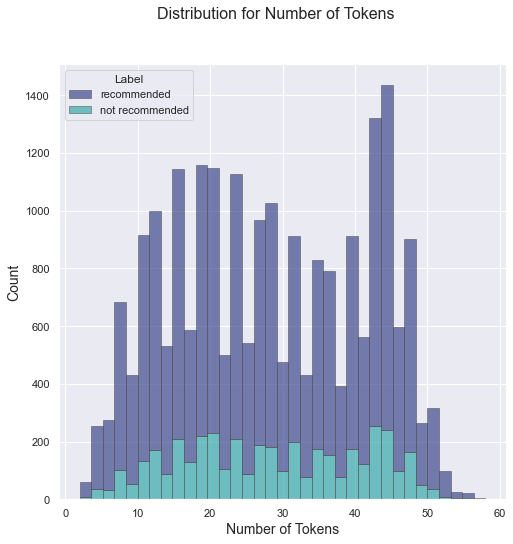

In [150]:
fig, ax = plt.subplots(1, figsize=SQUARE_PLOT_DIMENSIONS)
ax = sns.histplot(data=reviews_labeled, x='n_tokens', hue='Label', multiple='stack', palette='mako', edgecolor='.3', linewidth=.5, alpha=.7)
ax.set_xlabel('Number of Tokens', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
plt.suptitle('Distribution for Number of Tokens', fontsize=TITLE_FONTSIZE)
plt.savefig('../assets/eda/token_distribution.png')
plt.show()

**Analysis**
- Target class of `not-recommended` corresponds with a lower number of tokens in the review; the opposite is true for `recommended`

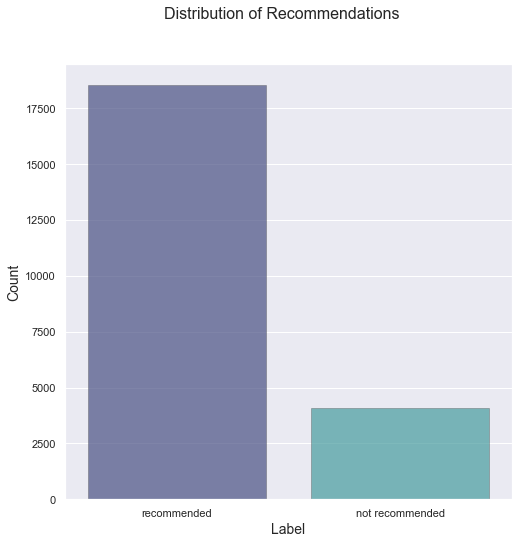

In [151]:
fig, ax = plt.subplots(1, figsize=SQUARE_PLOT_DIMENSIONS)
ax = sns.countplot(data=reviews_labeled, x='Label',palette='mako', edgecolor='.3', linewidth=.5, alpha=0.7)
ax.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
ax.set_xlabel('Label', fontsize=LABEL_FONTSIZE)
plt.suptitle('Distribution of Recommendations', fontsize=TITLE_FONTSIZE)
plt.savefig('../assets/eda/target_distribution.png')
plt.show()

**Analysis**
- We have class imbalance with more `recommended` labels

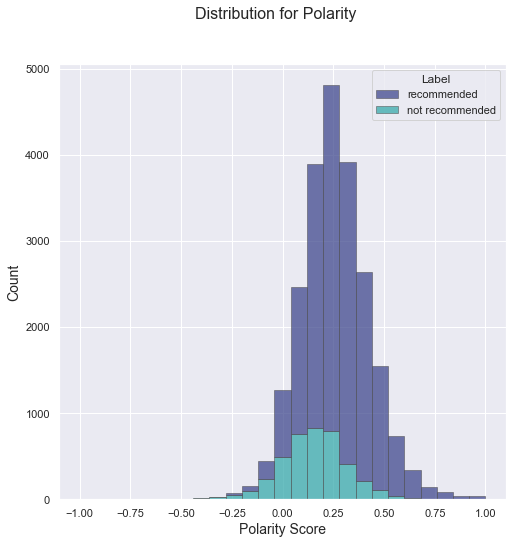

In [153]:
fig, ax = plt.subplots(1, figsize=SQUARE_PLOT_DIMENSIONS)
ax = sns.histplot(data=reviews_labeled, x='polarity', hue='Label', bins=25,  multiple='stack', palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Polarity Score', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
plt.suptitle('Distribution for Polarity', fontsize=TITLE_FONTSIZE)
plt.savefig('../assets/eda/polarity_distribution.png')
plt.show()

**Analysis**

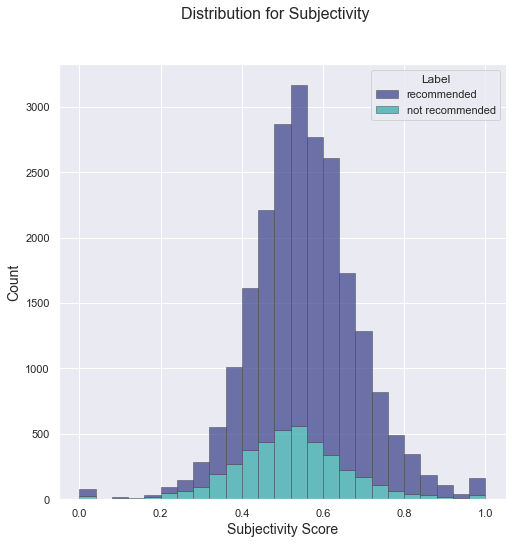

In [154]:
fig, ax = plt.subplots(1, figsize=SQUARE_PLOT_DIMENSIONS)
ax = sns.histplot(data=reviews_labeled, x='subjectivity', hue='Label', bins=25,  multiple='stack', palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Subjectivity Score', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
plt.suptitle('Distribution for Subjectivity', fontsize=TITLE_FONTSIZE)
plt.savefig('../assets/eda/subjectivity_distribution.png')
plt.show()

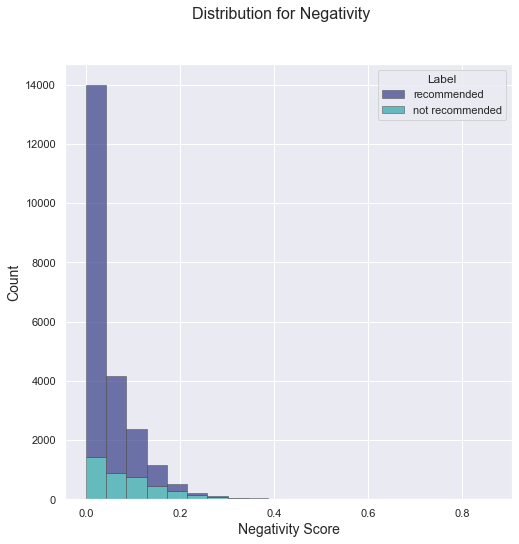

In [155]:
fig, ax = plt.subplots(1, figsize=SQUARE_PLOT_DIMENSIONS)
ax = sns.histplot(data=reviews_labeled, x='negative', hue='Label', bins=20,  multiple='stack', palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Negativity Score', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
plt.suptitle('Distribution for Negativity', fontsize=TITLE_FONTSIZE)
plt.savefig('../assets/eda/negativity_distribution.png')
plt.show()

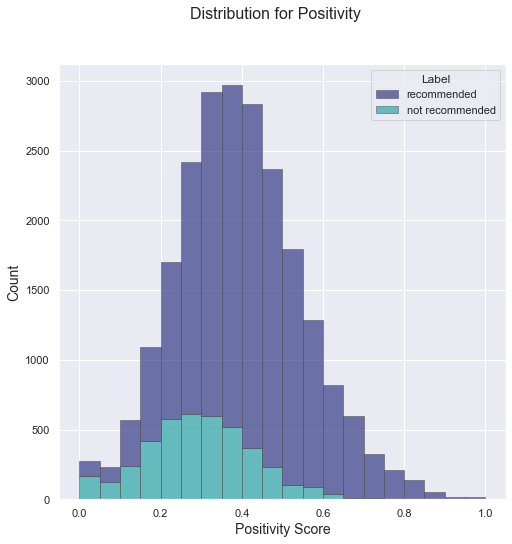

In [156]:
fig, ax = plt.subplots(1, figsize=SQUARE_PLOT_DIMENSIONS)
ax = sns.histplot(data=reviews_labeled, x='positive', hue='Label', bins=20,  multiple='stack', palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Positivity Score', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
plt.suptitle('Distribution for Positivity', fontsize=TITLE_FONTSIZE)
plt.savefig('../assets/eda/positivity_distribution.png')
plt.show()

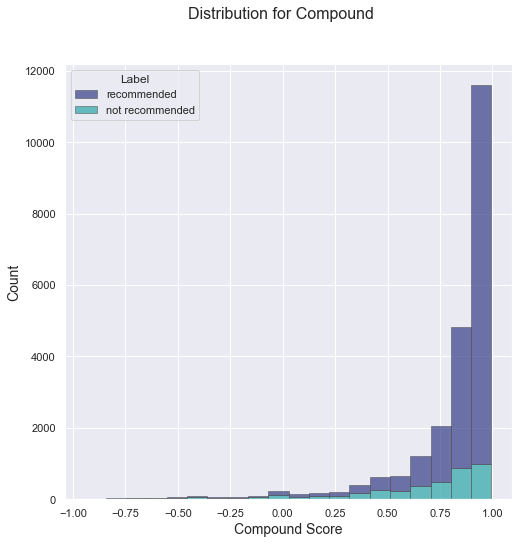

In [157]:
fig, ax = plt.subplots(1, figsize=SQUARE_PLOT_DIMENSIONS)
ax = sns.histplot(data=reviews_labeled, x='compound', hue='Label', bins=20,  multiple='stack', palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Compound Score', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Count', fontsize=LABEL_FONTSIZE)
plt.suptitle('Distribution for Compound', fontsize=TITLE_FONTSIZE)
plt.savefig('../assets/eda/compound_distribution.png')
plt.show()

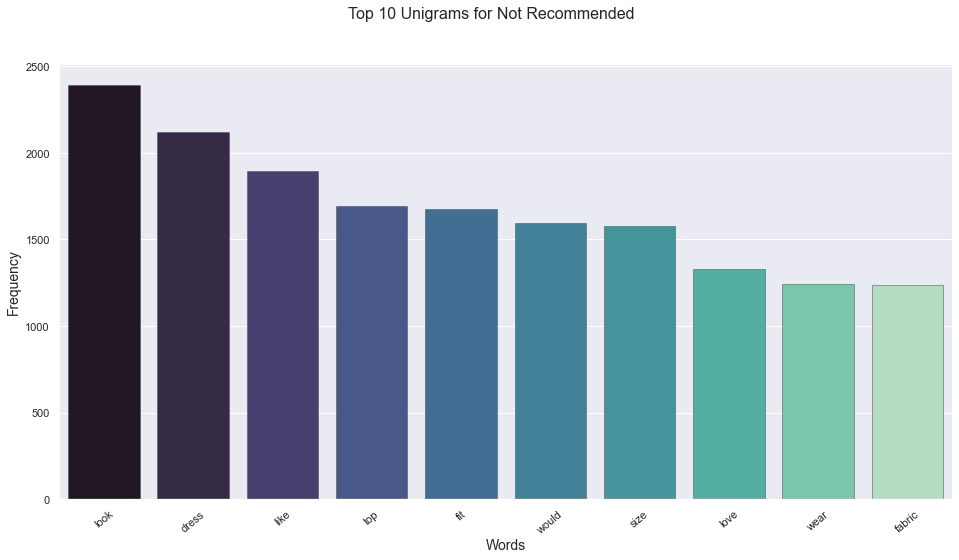

In [158]:
x, y = zip(*top_unigrams_positive)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for Not Recommended', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/unigram_positive_top10.png')
plt.show()

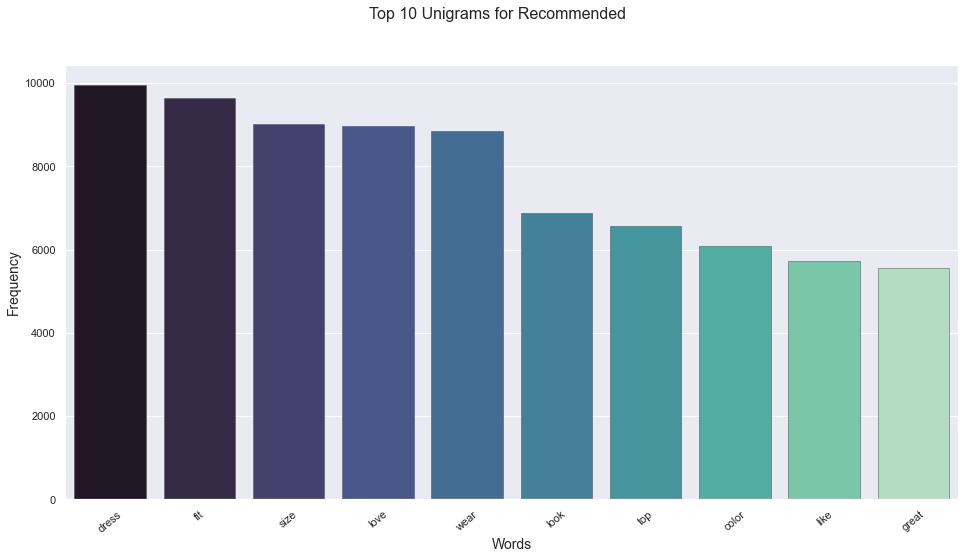

In [159]:
x, y = zip(*top_unigrams_negative)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Unigrams for Recommended', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/unigram_negative_top10.png')
plt.show()

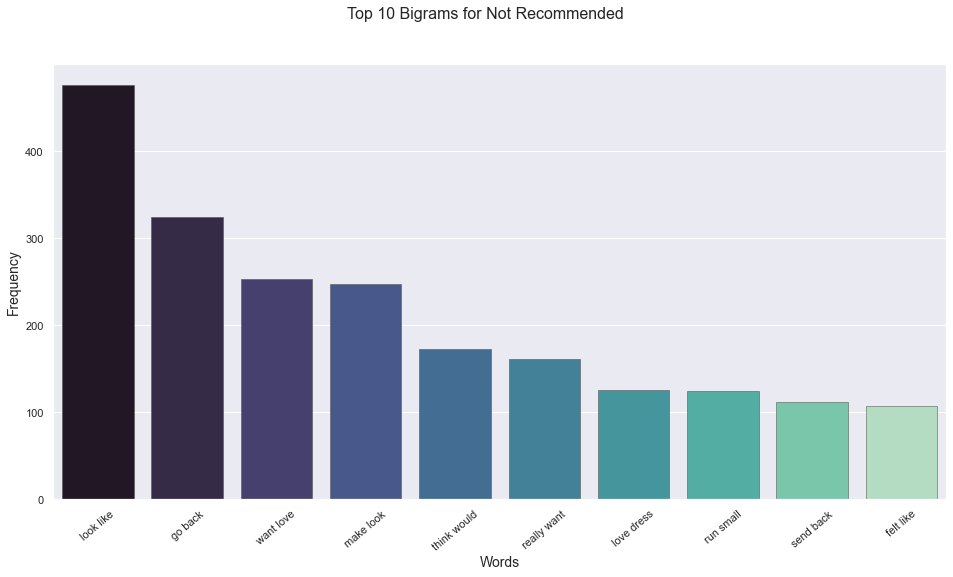

In [160]:
x, y = zip(*top_bigrams_positive)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Bigrams for Not Recommended', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/bigram_positive_top10.png')
plt.show()

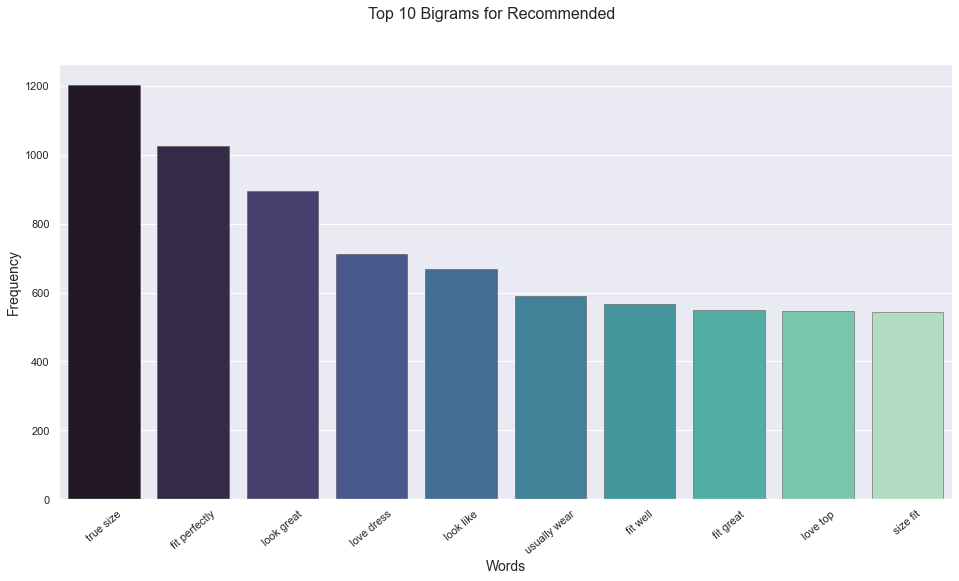

In [161]:
x, y = zip(*top_bigrams_negative)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Bigrams for Recommended', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/bigram_negative_top10.png')
plt.show()

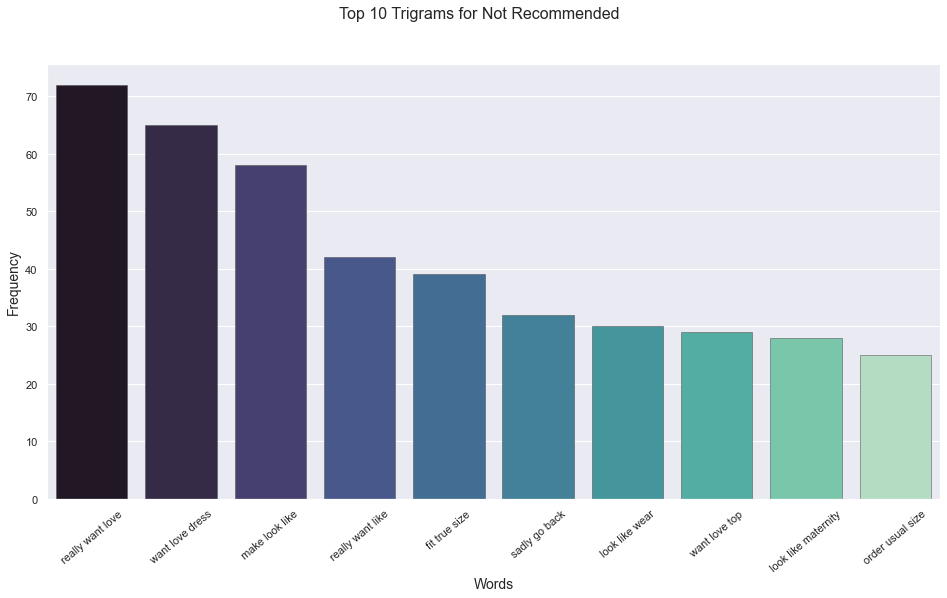

In [162]:
x, y = zip(*top_trigrams_positive)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Trigrams for Not Recommended', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/trigram_positive_top10.png')
plt.show()

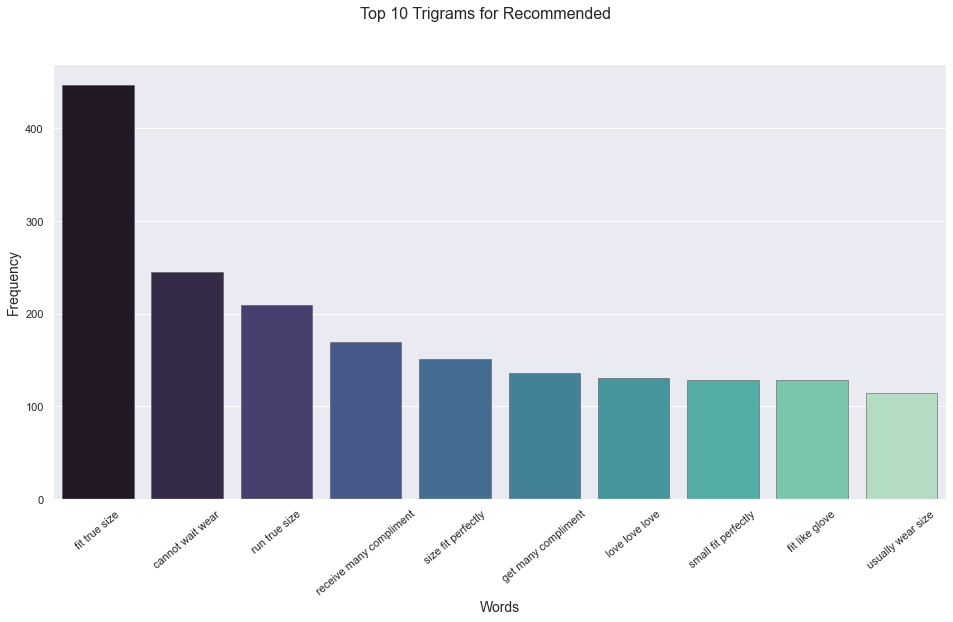

In [163]:
x, y = zip(*top_trigrams_negative)
fig, ax = plt.subplots(1, figsize=WIDE_PLOT_DIMENSIONS)
ax = sns.barplot(x=list(x), y=list(y), palette='mako', edgecolor='.3', linewidth=.5)
ax.set_xlabel('Words', fontsize=LABEL_FONTSIZE)
ax.set_ylabel('Frequency', fontsize=LABEL_FONTSIZE)
plt.suptitle('Top 10 Trigrams for Recommended', fontsize=TITLE_FONTSIZE)
plt.xticks(rotation=ROTATION_DEG, fontsize=WIDE_LABEL_FONTSIZE)
plt.savefig('../assets/eda/trigram_negative_top10.png')
plt.show()

In [164]:
# save featurized data
reviews_labeled.drop('Label', inplace=True, axis=1)
reviews_labeled.reset_index(inplace=True, drop=True)
reviews_labeled.to_csv('../data/interim/reviews_featurized.csv', index=False)